In [1]:
import os
import sys
from glob import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from utils import label_map_util
from utils import visualization_utils as vis_util
import random
import datetime

%matplotlib inline

In [2]:
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [3]:
LABELS = "data/udacity_label_map.pbtxt"
NUM_CLASSES = 4
IMAGE_SIZE = (12, 8)


In [4]:
label_map = label_map_util.load_labelmap(LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': u'Green'}, 2: {'id': 2, 'name': u'Red'}, 3: {'id': 3, 'name': u'Yellow'}, 4: {'id': 4, 'name': u'off'}}


secs=1.873391, scores=[ 0.98329723  0.00585221  0.00505794  0.00463184  0.00444621  0.00441959
  0.00438301  0.00411788  0.00410577  0.00400355], classes=[ 1.  1.  1.  4.  1.  4.  1.  4.  2.  2.]


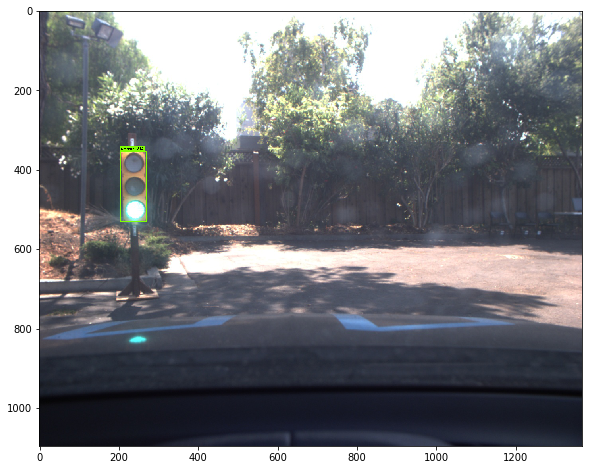

secs=1.196637, scores=[ 0.9960829   0.00536964  0.00466968  0.00459823  0.00378913  0.00374668
  0.00366522  0.00349632  0.00330009  0.00329166], classes=[ 1.  1.  4.  2.  3.  4.  4.  4.  4.  3.]


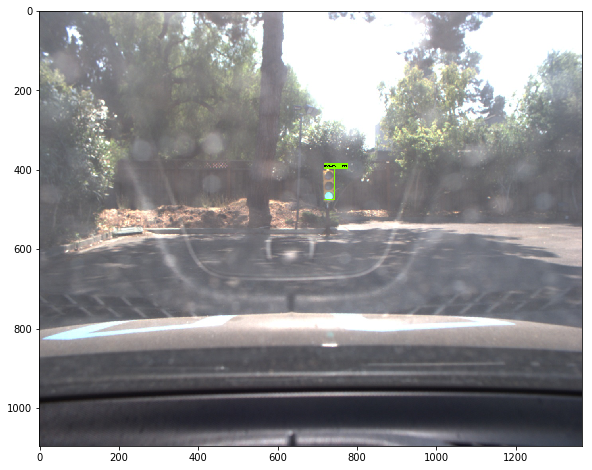

secs=1.186849, scores=[ 0.99272412  0.00482007  0.00411368  0.00405681  0.00397849  0.00391644
  0.00390275  0.0038747   0.00374603  0.00370899], classes=[ 1.  1.  4.  1.  1.  1.  1.  1.  1.  4.]


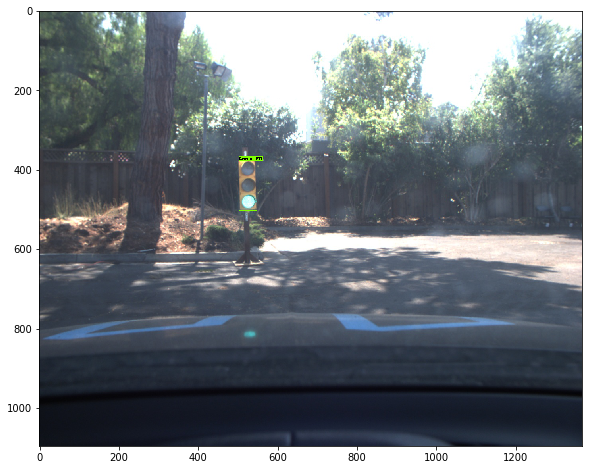

secs=1.156212, scores=[ 0.99006629  0.00489312  0.00482726  0.00458803  0.00426022  0.0040357
  0.00393556  0.00388648  0.00378564  0.00375376], classes=[ 1.  4.  2.  4.  4.  4.  1.  1.  1.  4.]


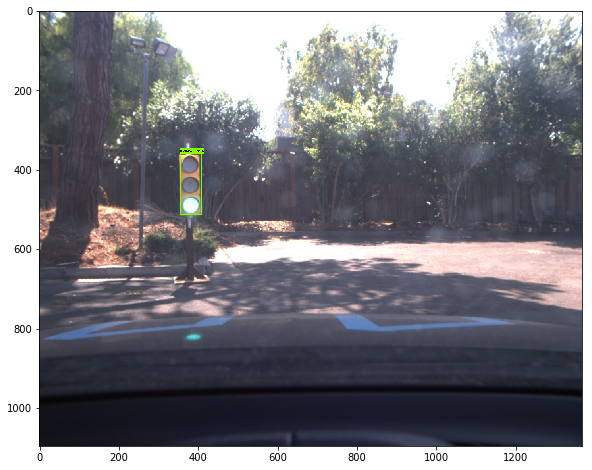

secs=1.155402, scores=[ 0.19062538  0.02720408  0.00446792  0.00426019  0.00405262  0.00381496
  0.00380488  0.00377947  0.00369961  0.00369136], classes=[ 1.  1.  4.  1.  2.  4.  1.  3.  1.  4.]


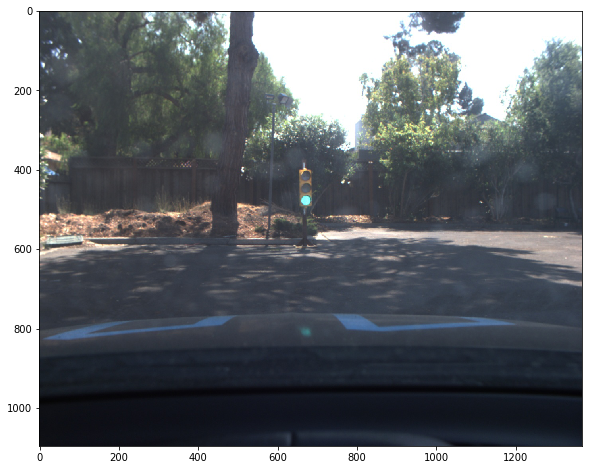

secs=1.149356, scores=[ 0.92190385  0.00955071  0.00921081  0.0057135   0.00540037  0.00440639
  0.00440364  0.00438196  0.00430905  0.00430668], classes=[ 1.  1.  1.  4.  2.  3.  2.  3.  1.  4.]


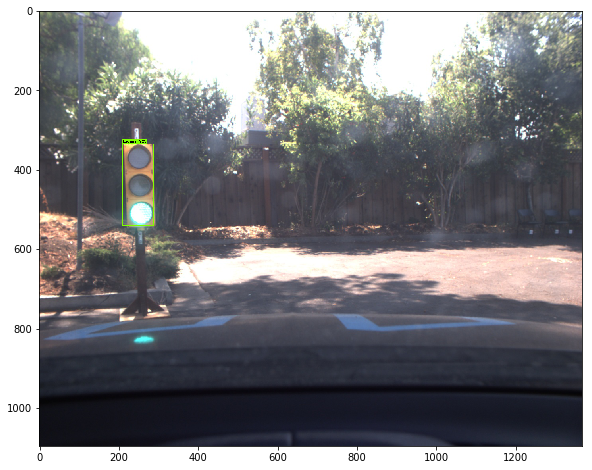

secs=1.223798, scores=[ 0.10931961  0.04100499  0.02903908  0.00896318  0.00517121  0.00507052
  0.00497647  0.00489795  0.00456945  0.00438756], classes=[ 1.  2.  3.  4.  2.  2.  4.  2.  1.  1.]


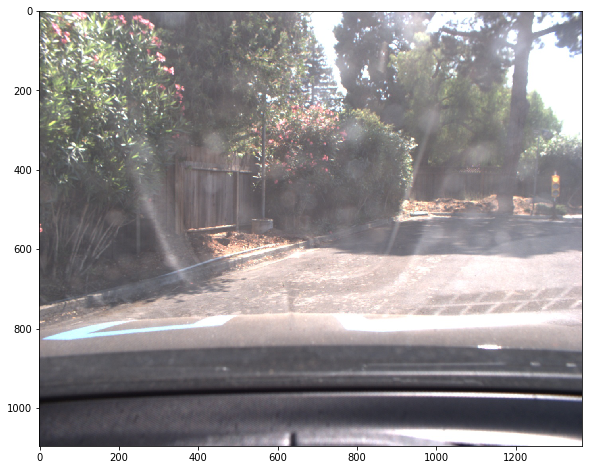

secs=1.18872, scores=[ 0.96395385  0.00450165  0.00433696  0.00421378  0.00404836  0.00393558
  0.003776    0.003759    0.00363409  0.0034526 ], classes=[ 2.  2.  3.  3.  3.  3.  3.  2.  4.  1.]


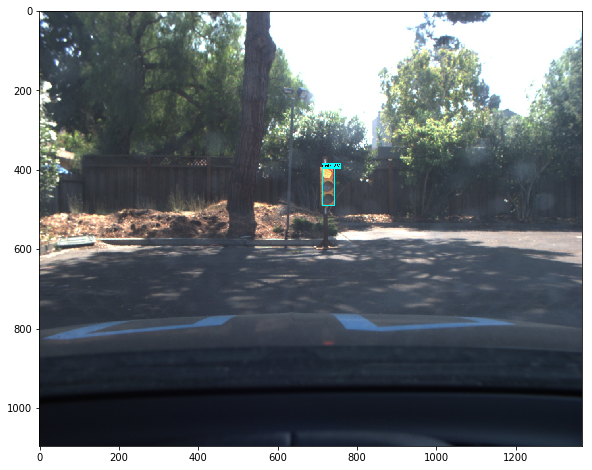

secs=1.18142, scores=[ 0.87509763  0.00506749  0.00473294  0.00468104  0.00439618  0.00421984
  0.00421247  0.00413396  0.00412982  0.00395065], classes=[ 1.  4.  1.  1.  2.  4.  1.  1.  4.  3.]


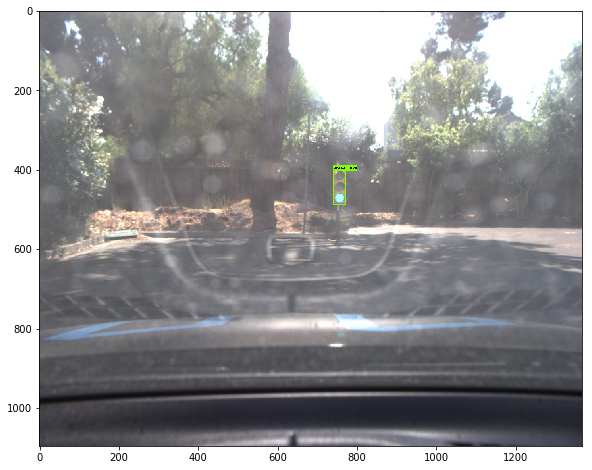

In [9]:
## Test model
# MODEL = "models/rcnn_resnet101/frozen_inference_graph.pb"
# MODEL = "models/rcnn/frozen_inference_graph.pb"
MODEL = "models/udacity_site/frozen_inference_graph.pb"
model = load_graph(MODEL)

IMAGES = "data-downloads/alex-lechner-udacity-traffic-light-dataset/udacity_testarea_rgb"
TEST_IMAGES = glob(os.path.join(IMAGES, "*.jpg"))
random.shuffle(TEST_IMAGES)

SITE_OUTPUT = "output/site"

with model.as_default():
    with tf.Session(graph=model) as sess:
        image_tensor = model.get_tensor_by_name('image_tensor:0')
        detect_boxes = model.get_tensor_by_name('detection_boxes:0')
        detect_scores = model.get_tensor_by_name('detection_scores:0')
        detect_classes = model.get_tensor_by_name('detection_classes:0')
        num_detections = model.get_tensor_by_name('num_detections:0')
        
        for idx, img_path in enumerate(TEST_IMAGES[1:10]):
            start = datetime.datetime.now() 
            image = Image.open(img_path)
            image_np = load_image_into_numpy_array(image)
            image_expanded = np.expand_dims(image_np, axis=0)
            
            (boxes, scores, classes, num) = sess.run(
                [detect_boxes, detect_scores, detect_classes, num_detections],
                feed_dict={image_tensor: image_expanded})
            total = datetime.datetime.now() - start

            print("secs={}, scores={}, classes={}".format(total.total_seconds(), scores[0], classes[0]))
            
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, 
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                line_thickness=2)
            
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.savefig(os.path.join(SITE_OUTPUT, os.path.basename(img_path)))
            plt.show()

secs=1.121913, scores=[ 0.9868418   0.97658622  0.49061221  0.01216306  0.00631106  0.00591382
  0.0058412   0.0057253   0.00559127  0.0054695 ], classes=[ 1.  1.  1.  1.  1.  1.  4.  1.  1.  1.]


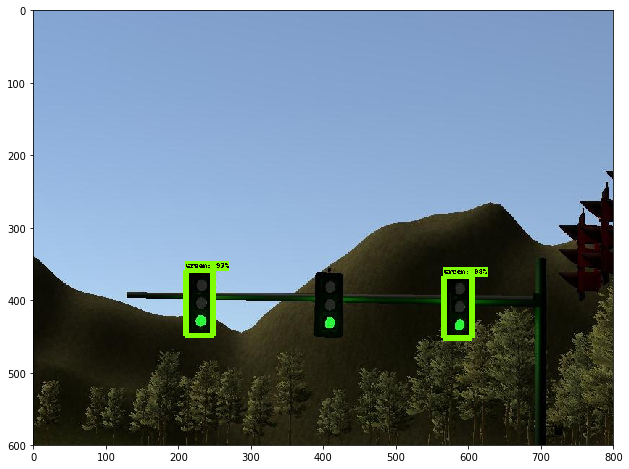

secs=0.527345, scores=[ 0.99906904  0.99597508  0.99566972  0.00657303  0.00457548  0.00418118
  0.00385765  0.00372246  0.00368269  0.00362285], classes=[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


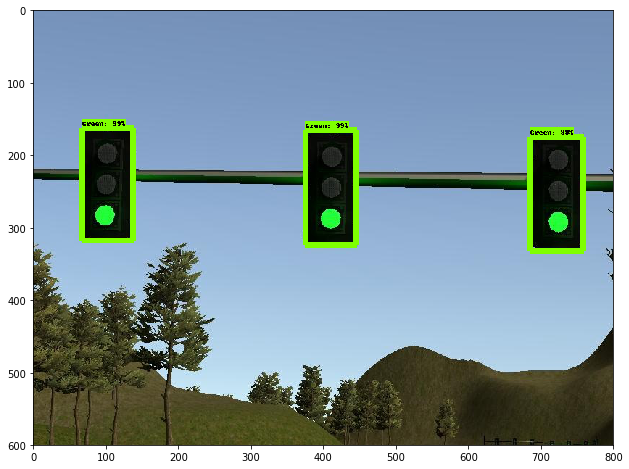

secs=0.538234, scores=[ 0.00765191  0.00754795  0.00739458  0.00734127  0.00727649  0.00716829
  0.00682702  0.00676725  0.00659323  0.00618464], classes=[ 1.  1.  2.  3.  1.  1.  1.  3.  1.  2.]


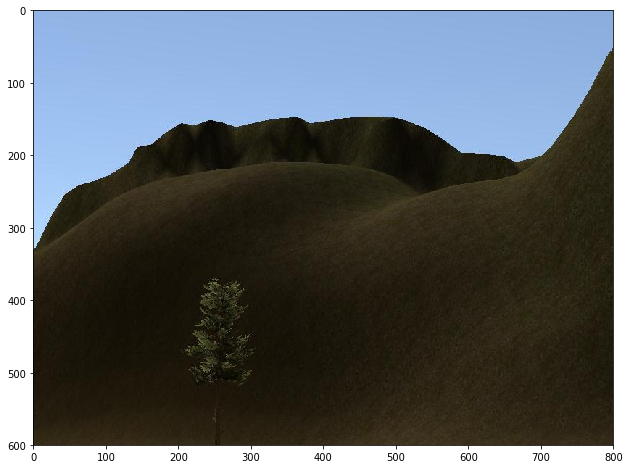

secs=0.515512, scores=[ 0.98609507  0.9674933   0.94719744  0.04346412  0.04188903  0.0375416
  0.0250001   0.01974237  0.01299076  0.01013649], classes=[ 1.  1.  1.  2.  2.  2.  2.  2.  2.  2.]


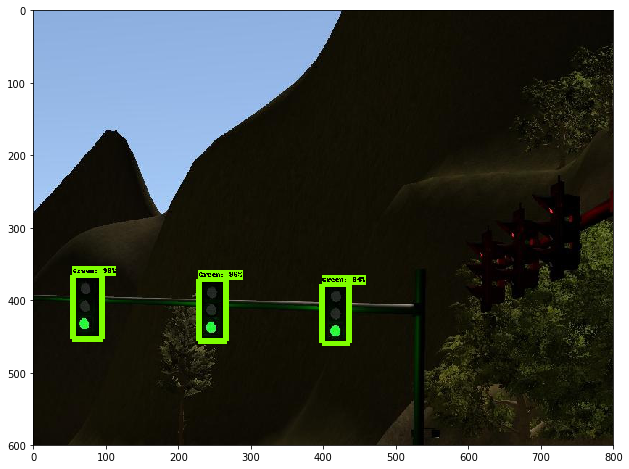

secs=0.532465, scores=[ 0.00474176  0.00424248  0.00391003  0.00380476  0.00378478  0.00371281
  0.0036673   0.00365789  0.00365376  0.00361477], classes=[ 3.  1.  2.  3.  2.  4.  1.  3.  4.  3.]


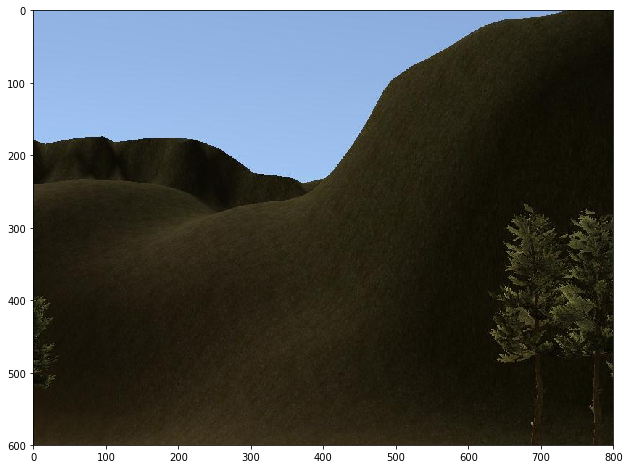

secs=0.532496, scores=[ 0.97236586  0.96107382  0.95344788  0.00581395  0.00488254  0.00472921
  0.00456333  0.00456136  0.00454405  0.00432152], classes=[ 2.  2.  2.  2.  3.  1.  2.  4.  1.  4.]


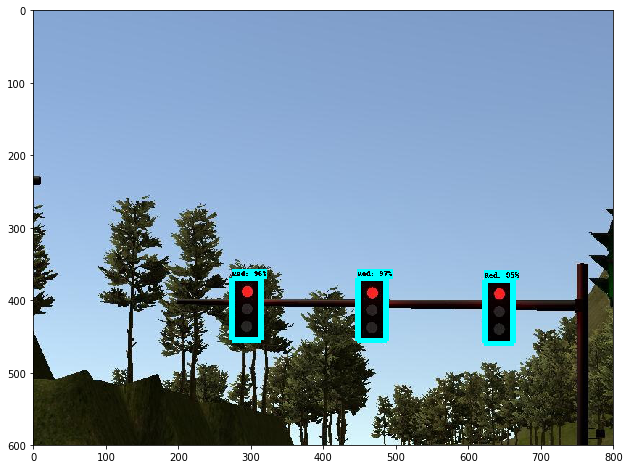

secs=0.555203, scores=[ 0.97883713  0.14232358  0.00766338  0.00613918  0.00611762  0.00594384
  0.00591547  0.00587522  0.00583362  0.00573076], classes=[ 2.  2.  4.  1.  2.  3.  3.  3.  3.  3.]


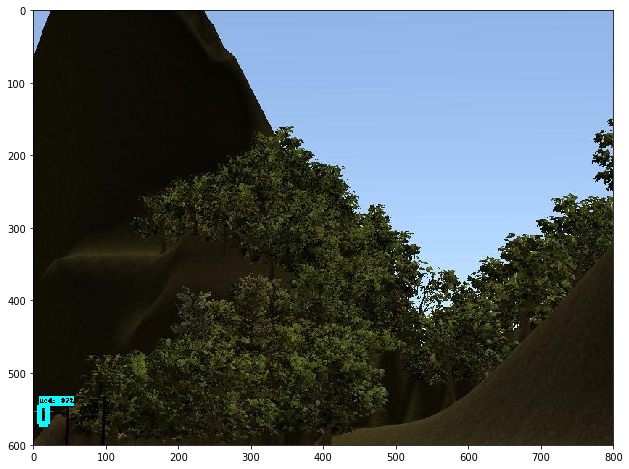

secs=0.565298, scores=[ 0.99146563  0.9897272   0.97039247  0.01599416  0.00706988  0.00660944
  0.00642451  0.0053438   0.00514658  0.00510245], classes=[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


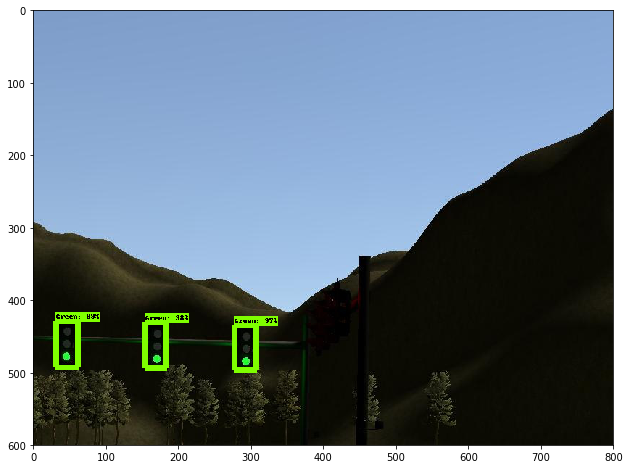

secs=0.549197, scores=[ 0.99882334  0.99607265  0.99589431  0.0071959   0.00488807  0.00450421
  0.00416517  0.0038346   0.00371211  0.00361274], classes=[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  4.]


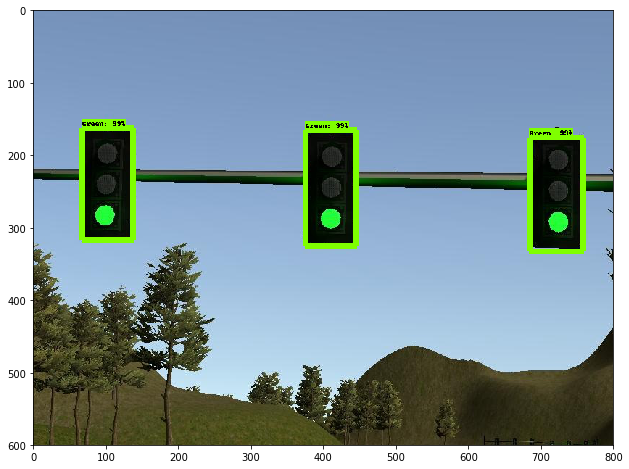

In [7]:
MODEL = "models/udacity_simulator/frozen_inference_graph.pb"
model = load_graph(MODEL)
IMAGES = "data-downloads/alex-lechner-udacity-traffic-light-dataset/simulator_dataset_rgb"
SIM_OUTPUT = "output/simulator"

classes = ['Green', 'Red', 'Yellow', 'Unknown']
TEST_IMAGES = []

for i in classes:
    TEST_IMAGES += glob(os.path.join(os.path.join(IMAGES, i), "*.jpg"))

    random.shuffle(TEST_IMAGES)


with model.as_default():
    with tf.Session(graph=model) as sess:
        image_tensor = model.get_tensor_by_name('image_tensor:0')
        detect_boxes = model.get_tensor_by_name('detection_boxes:0')
        detect_scores = model.get_tensor_by_name('detection_scores:0')
        detect_classes = model.get_tensor_by_name('detection_classes:0')
        num_detections = model.get_tensor_by_name('num_detections:0')
        
        for idx, img_path in enumerate(TEST_IMAGES[1:10]):
            start = datetime.datetime.now()            
            image = Image.open(img_path)
            image_np = load_image_into_numpy_array(image)
            image_expanded = np.expand_dims(image_np, axis=0)
            
            (boxes, scores, classes, num) = sess.run(
                [detect_boxes, detect_scores, detect_classes, num_detections],
                feed_dict={image_tensor: image_expanded})
            
            total = datetime.datetime.now() - start

            print("secs={}, scores={}, classes={}".format(total.total_seconds(), scores[0], classes[0]))

            
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, 
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.savefig(os.path.join(SIM_OUTPUT, os.path.basename(img_path)))

            plt.show()

In [ ]:
TEST_IMAGES